The objective of the project is to try to fit a base game (when it is divided into training and testing) in one of the audience approval categories that will be created by me during the project, based on approval percentage.

In [49]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


removing some categories that I thought were unnecessary
decided to remove the genres because when I was going to use One Hot Encoding it would be a very polluted base by several columns, which would delay the analysis even more
I also thought that the studio that developed the games would be more relevant than their publisher, so I removed the publisher

In [36]:
steam_data = pd.read_csv('steam.csv')
# print(steam_data.columns)
steam_data = steam_data.drop(columns=['appid', 'name', 'release_date', 'developer','publisher', 'platforms', 'genres', 'steamspy_tags'])
# print(steam_data)

In [37]:
#finding the median of the estimated number of game owners and replacing the values ​​in the 'owners' column with the median

owners = steam_data['owners']
owners_median = []

for i in owners:
    #splitting the strings in two for each element in the 'owners' column, which are normally represented by a string "initial value - final value"
    temp = i.split('-')

    #now transforming string elements into integers using list comprehension
    elements = [int(elemento) for elemento in temp]

    #inverting the order of elements, to put the maximum estimated value of owners before the minimum value
    invert = elements[::-1]

    #taking the median of the two values ​​and adding to a new list
    mediana = statistics.median(invert)
    owners_median.append(float(mediana))

owner_df = pd.DataFrame(owners_median, columns = ['median_of_owners'])

steam_data = steam_data.drop(['owners'], axis = 1)
steam_data = steam_data.join(owner_df['median_of_owners'])

In [38]:
#turning categories into binary numbers
"""
Knowing that the "categories" column is used to say what type of game itself, I will first find out how many categories are possible

Then I'll turn all the categories into just two, single and multiplayer. This will serve to simplify the analysis
"""




categories = steam_data['categories']
strings = []

"""
  There are some cases where a game can have multiple categories, and in those cases, they are separated by ';', so I'll break them down by that.
"""

for element in categories:
    strings.append(element.split(';'))

#the list 'strings' is made up of lists of strings. Variable 'temp2' will only have strings, no lists inside
temp = [element for element in strings]
temp_list = []

for element in temp:
    temp_list.extend(element)

#eliminating duplicate elements by transforming to set
categories_set = set(temp_list)

In [39]:
print(categories_set)

{'Includes Source SDK', 'In-App Purchases', 'Captions available', 'Single-player', 'Online Co-op', 'Steam Turn Notifications', 'MMO', 'Local Co-op', 'SteamVR Collectibles', 'Mods (require HL2)', 'Co-op', 'Steam Workshop', 'Steam Trading Cards', 'Steam Leaderboards', 'Steam Cloud', 'Partial Controller Support', 'Includes level editor', 'Steam Achievements', 'Valve Anti-Cheat enabled', 'Mods', 'Online Multi-Player', 'Stats', 'Commentary available', 'Full controller support', 'Local Multi-Player', 'Multi-player', 'Cross-Platform Multiplayer', 'Shared/Split Screen', 'VR Support'}



The categories were organized like this:

Multiplayer (here will also fit the categories: Co-op, Online Co-op, Online Multi-Player, Cross-Platform Multiplayer, Local Multi-Player, Local Co-op, Shared/Split Screen, and MMO);

Singleplayer;

Hybrid (if the game has the option to be played both multiplayer and singleplayer).

In [40]:
# The following loop will check if a game is hybrid, single-player, or multi-player, and add the right category for each game to 'new_changed_list'
multiplayer = ['Multi-player', 'Co-op', 'Online Co-op', 'Online Multi-Player', 'Cross-Platform Multiplayer', 'Local Multi-Player', 'Local Co-op', 'Shared/Split Screen', 'MMO']

condensed_category = []

for i in range(len(temp_list)):
    for multiplayer_element in multiplayer:
        if 'Single-player' in temp_list[i] and multiplayer_element in temp_list[i]:
            condensed_category.append('Hybrid')
            break
        elif multiplayer_element in temp_list[i]:
            condensed_category.append('Multiplayer')
            break
        elif multiplayer_element not in temp_list[i]:
            condensed_category.append('Singleplayer')
            break

In [41]:
#replacing the old category column with the new one
new_category = pd.DataFrame(condensed_category, columns = ['categories'])

steam_data = steam_data.drop(columns=['categories'], axis=1)
steam_data = steam_data.join(new_category['categories'])
print(steam_data)

       english  required_age  achievements  positive_ratings  \
0            1             0             0            124534   
1            1             0             0              3318   
2            1             0             0              3416   
3            1             0             0              1273   
4            1             0             0              5250   
...        ...           ...           ...               ...   
27070        1             0             7                 3   
27071        1             0             0                 8   
27072        1             0            24                 0   
27073        1             0             0                 2   
27074        1             0             0                 4   

       negative_ratings  average_playtime  median_playtime  price  \
0                  3339             17612              317   7.19   
1                   633               277               62   3.99   
2                   398 

In [42]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(steam_data[['categories']]).toarray())
steam_data = steam_data.join(enc_df)
steam_data = steam_data.drop(columns=['categories'], axis=1)
print(steam_data)

       english  required_age  achievements  positive_ratings  \
0            1             0             0            124534   
1            1             0             0              3318   
2            1             0             0              3416   
3            1             0             0              1273   
4            1             0             0              5250   
...        ...           ...           ...               ...   
27070        1             0             7                 3   
27071        1             0             0                 8   
27072        1             0            24                 0   
27073        1             0             0                 2   
27074        1             0             0                 4   

       negative_ratings  average_playtime  median_playtime  price  \
0                  3339             17612              317   7.19   
1                   633               277               62   3.99   
2                   398 

Joining the positive_ratings and negative_ratings columns into one, which will be expressed as a percentage. Also, I will only select the games that have more ratings (quantity) than 100 (this number can be changed)


Example:
If the game has 70 upvotes and 30 downvotes, the new column will have "70" as its value.

In [43]:
pr = steam_data['positive_ratings']
nr = steam_data['negative_ratings']
ratings = pr+nr

#Selecting only the lines above X ratings, the value can be changed below
x = 100

ratings = pd.DataFrame(ratings, columns=['ratings'])

steam_data = steam_data.join(ratings['ratings'])
lista_av = []

for i in range(len(steam_data)):
    if steam_data['ratings'][i] < x: #change this number 100 if you want to decrease or increase the base
        lista_av.append(i)

steam_data = steam_data.drop(lista_av)

#creating the percentage column

pr = steam_data['positive_ratings']
nr = steam_data['negative_ratings']
ratings = pr+nr

ratings = tuple(ratings)
pr = tuple(pr)

assessments = []

#taking the percentage of 'approval' (positive votes versus negative votes)
for i in range(len(steam_data)):
    res = pr[i] * 100 / ratings[i]
    assessments.append(res)

steam_data = steam_data.drop(columns=['positive_ratings', 'negative_ratings', 'ratings'], axis = 1)

steam_data['ratings'] = assessments

steam_data = steam_data.dropna()


I will mark the following categories for the evaluations, based on the previous process:

Horrible: ratings < 40%

Bad: 40% <= ratings < 55%

Median: 55% <= ratings < 70%

Good: 70% <= ratings < 90%

Great: ratings >= 90%

In [44]:
#checking different categories for reviews
steam_data.reset_index(drop=True, inplace=True)
rt = steam_data['ratings']


#basically the following loops will assign different categories to the evaluations, and these categories will be used as the target attribute of the AIs

#transforming ratings into floats numbers and saving to a list
float_ratings = []
for i in range(len(steam_data)):
  float_ratings.append(float(steam_data['ratings'][i]))

rt_temp = []

#assinalando cada categoria, de acordo com o que foi descrito acima, em uma nova lista de strings que será a nova coluna de ratings
for i in range(len(steam_data)):
    if float_ratings[i] < 40:
        rt_temp.append(0)
    elif float_ratings[i] >= 40 and float_ratings[i] < 55:
        rt_temp.append(1)
    elif float_ratings[i] >= 55 and float_ratings[i] < 70:
        rt_temp.append(2)
    elif float_ratings[i] >= 70 and float_ratings[i] < 90:
        rt_temp.append(3)
    elif float_ratings[i] >= 90:
        rt_temp.append(4)

steam_data = steam_data.drop(columns=['ratings'], axis=1)
steam_data['ratings'] = rt_temp

In [51]:
#splitting the base into testing and training
X = steam_data.drop('ratings', axis = 1)
y = steam_data['ratings']
print(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

      english  required_age  achievements  average_playtime  median_playtime  \
0           1             0             0             17612              317   
1           1             0             0               277               62   
2           1             0             0               187               34   
3           1             0             0               258              184   
4           1             0             0               624              415   
...       ...           ...           ...               ...              ...   
8757        1             0            26                 0                0   
8758        1             0             0                 0                0   
8759        1             0            28               347              347   
8760        1             0             0                 0                0   
8761        1             0             0                 0                0   

      price  median_of_owners    0    1

Target on train data [4 3 4 ... 2 3 3]
accuracy_score on train dataset :  0.9082015326919941
Target on test data [3 3 3 ... 3 3 3]
accuracy_score on test dataset :  0.41422594142259417


<AxesSubplot:>

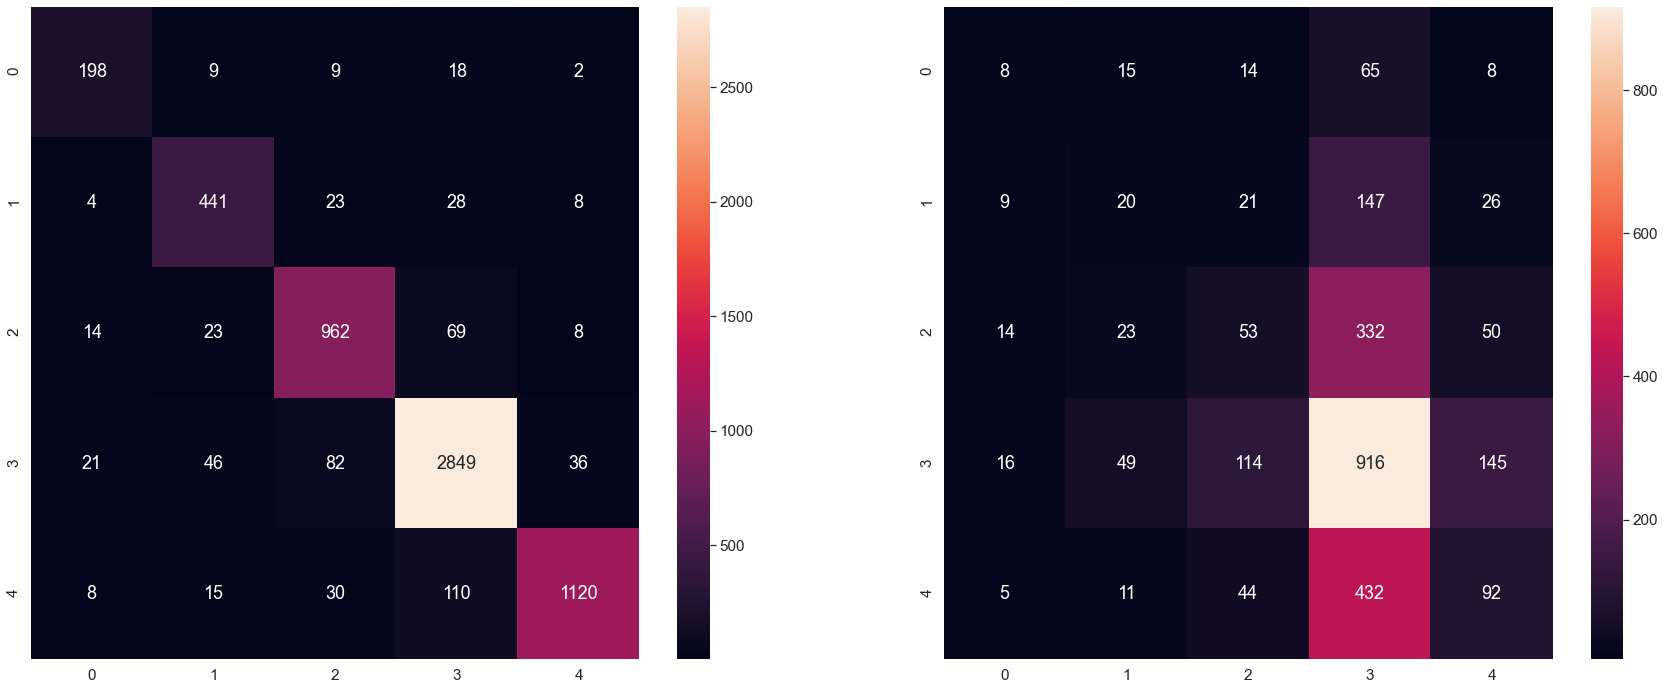

In [64]:
KNNModel = KNeighborsClassifier(p=2, n_neighbors=15, weights = 'distance', algorithm = 'auto')
KNNModel.fit(X_train, y_train)

# predict the target on the train dataset
predict_train = KNNModel.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = KNNModel.predict(X_test)
print('Target on test data',predict_test) 


# Accuracy Score on test dataset
nbscore = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ',nbscore)


f, axes = plt.subplots(1, 2, figsize=(30, 12))
pred = confusion_matrix(y_train, predict_train)

sb.heatmap(pred, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, predict_test), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])



sb.set(color_codes=True)
plt.figure(1, figsize=(30, 12)

plt.title("Confusion Matrix")

sb.set(font_scale=1.4)
ax = sb.heatmap(confusion_matrix(y_train, predict_train), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})


ax.set(ylabel="True Label", xlabel="Predicted Label")



